### Import relevant libraries

In [1]:
# import the plotting library and logging library
using PyPlot, Logging
Logging.configure(filename="linear.log", level=DEBUG)

# start all the workers
if length(workers()) > 1; rmprocs(workers()); end
addprocs(12)
# import the relevant libraries for each worker
@everywhere using Optim, PyCall

# Transition in P first

### Parameters for the simulation

In [2]:
# dimensionality of receptive field and # of neurons
D, M = 4, 100
# range of the # of training trials to simulate
Ps = round(Int64, logspace(log10(D), 3, 20))
# ranges of noise stds wiht signal std fixed at 1
σns = logspace(-1/2, 1/2, 20)
ntrial = 1000

1000

### Run the actual simulation

In [3]:
# stimulated vs oracle errors
errs = SharedArray(Float64, length(Ps), length(σns), ntrial)
errs_oracle = zeros(length(Ps), length(σns))

for (ixP, P) in enumerate(Ps), (ixσn, σn) in enumerate(σns)
    debug("ixP: $ixP, ixσn: $ixσn") # logging to keep track of progress
    # oracle error
    errs_oracle[ixP, ixσn] = 1 - (1 + σn^2 + M/D - sqrt((1 + σn^2 - M/D)^2 + 4*M/D*σn^2)) / 2
    @sync @parallel for ix in 1:ntrial
        # random receptive fields
        X = randn(M, D) / sqrt(D)
        # training and test stimulus
        θtrains = qr(randn(D, P)')[1]' * sqrt(P)
        θtest = randn(D)
        # training and test response
        rtrains = X * θtrains + randn(M, P) * σn
        rtest = X * θtest + randn(M) * σn
        # training reponse covariance
        Σ = θtrains * θtrains' + eye(D) * σn^2 * D
        Σinv = inv(Σ)
        # optimal linear decoder first infers the receptive fields
        Xhat = (inv(θtrains * θtrains' + D * σn^2 * eye(D)) * θtrains * rtrains')'
        # deocde the test stimulus
        θx = inv(Xhat'* Xhat + σn^2 * (1 + trace(Σinv)) * eye(D)) * Xhat' * rtest
                
        errs[ixP, ixσn, ix] = sum((θx - θtest).^2) / D
    end
end

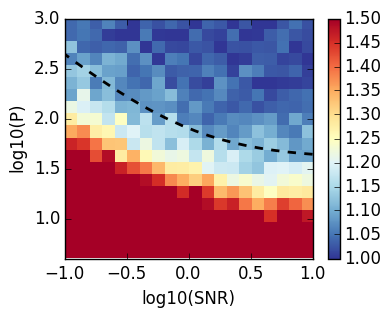

In [4]:
figure(figsize=(4, 3))

# plot the of the trained decoder's error to the 
imshow(squeeze(mean(errs, 3), 3)[:, end:-1:1] ./ errs_oracle[:, end:-1:1],
    extent=[extrema(log10(1 ./ σns.^2))..., extrema(log10(Ps))...],
interpolation="nearest", aspect="auto", cmap="RdYlBu_r", origin="lower", vmin=1, vmax=1.5)
# theoretically predicted transition boundary in the # of trials
plot(log10(1 ./ σns.^2), log10(10 * D * (1 + σns.^2)), "k--", linewidth=2)
colorbar()
xlim(extrema(log10(1 ./ σns.^2))); ylim(extrema(log10(Ps)))
xlabel("log10(SNR)"); ylabel("log10(P)")
savefig("linear.approach.eps")

# Sufficient number of trials and neurons together

### Simulation parameters

In [13]:
D = 20
Ms = round(Int64, logspace(log10(D), 3, 20))
Ps = round(Int64, logspace(log10(D), 3, 20))
# signal std is fixed at 1
σn = sqrt(1)
# number of trials for each parameter combination to average over
ntrial = 100

100

### Theoretical decoding error

In [6]:
# computing theoretically predicted decoding performance

# polynomial in the performance expression
function f1(P, M, D, σn)
    p, m = P / D, M / D
    snr = 1 / σn^2
    rst = (m - 1)^2 * p^2 * snr^4 + 2 * p * (1 + p) * (1 + m) * snr^3
    rst += (1 + 4 * p + 2 * m * p + p^2) * snr^2 + 2 * (1 + p) * snr + 1
end

# resulting r2 performance
function r2_opt1(P, M, D, σn)
    p, m = P / D, M / D
    snr = 1 / σn^2
    rst = (m - 1) * p * snr^2 + sqrt(f1(P, M, D, σn))
    rst = rst / (1 + (1 + p) * snr) + 1
    return 1 - 2 / rst
end

r2_opt1 (generic function with 1 method)

### Run the simulations

In [11]:
errs = SharedArray(Float64, length(Ps), length(Ms), ntrial)
errs_theory = zeros(length(Ps), length(Ms))

for (ixP, P) in enumerate(Ps), (ixM, M) in enumerate(Ms)
    debug("ixP: $ixP, ixM: $ixM")
    errs_theory[ixP, ixM] = 1 - r2_opt1(P, M, D, σn)
    @sync @parallel for ix in 1:ntrial
        # random receptive fields
        X = randn(M, D) / sqrt(D)
        # training and test stimulus
        θtrains = qr(randn(D, P)')[1]' * sqrt(P)
        θtest = randn(D)
        # training and test response
        rtrains = X * θtrains + randn(M, P) * σn
        rtest = X * θtest + randn(M) * σn
        # response covariance and inverse
        Σ = θtrains * θtrains' + eye(D) * σn^2 * D
        Σinv = inv(Σ)
        # inferring the receptive field then decoding stimulus
        Xhat = (inv(θtrains * θtrains' + D * σn^2 * eye(D)) * θtrains * rtrains')'
        θx = inv(Xhat'* Xhat + σn^2 * (1 + trace(Σinv)) * eye(D)) * Xhat' * rtest
        # store the error
        errs[ixP, ixM, ix] = sum((θx - θtest).^2) / D
    end
end

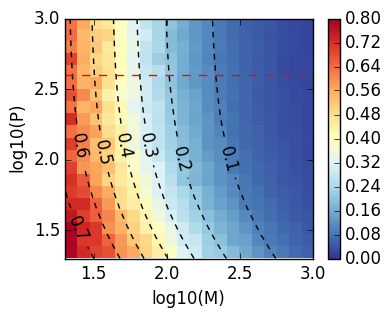

PyObject <matplotlib.text.Text object at 0x7f4992875d30>

In [12]:
figure(figsize=(4, 3))
PyPlot.locator_params(nbins=4)
# plot the average simulated errors
imshow(squeeze(mean(errs, 3), 3), extent=[extrema(log10(Ms))..., extrema(log10(Ps))...],
    interpolation="nearest", aspect="auto", cmap="RdYlBu_r", origin="lower", vmin=0, vmax=0.8)
    colorbar()
# overlap with contours of theoretically calculated decoding performance
c = contour(log10(Ms), log10(Ps), errs_theory, vmin=0, vmax=0.8, linewidths=1, colors="k")
# specify the style of the contour curves
for x in c[:collections]
    x[:set_dashes]([(0, (4.0, 4.0))])
end
# label the contours
clabel(c, fmt="%0.1f")

# horizontal trasntion line for the sufficient number of trials
PyPlot.axhline(log10(10 * D * (1 + σn^2)), linestyle="--", linewidth=1, color="r")

xlabel("log10(M)"); ylabel("log10(P)")